# Study 2_1 - Recording-level and window-level signal quality assessment
This notebook constitutes the second part of Study 2, which aims to characterise the structure and quality of the long-term single-lead ECG recordings in the dataset.
While the first Study 2 notebook describes the temporal organisation of the recordings (Study 2.0: dataset structure, seizure occurrences, inter-seizure intervals, time-of-day distributions), the present notebook focuses on signal-centric characterisation.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import welch
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from src.hrv_epatch.io.tdms import load_tdms_from_path
from scipy.signal import butter, filtfilt, iirnotch, welch

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from src.hrv_epatch.dataset.segments import build_segment_index
from src.hrv_epatch.plots.plotstyle import palette
from src.hrv_epatch.dataset.quality import (
    plot_all_psds,
    compute_spectral_uniqueness,
    compute_recording_quality,
    classify_recordings,
    compute_window_quality_vs_seizure,
)

## Load dataframe

In [2]:
OUT_DIR = Path(r"E:\Speciale - Results\Datastruct")

df_rec = pd.read_csv(
    OUT_DIR / "recordings_index.csv",
    parse_dates=["recording_start", "recording_end"],
)

df_evt = pd.read_csv(
    OUT_DIR / "seizure_events.csv",
    parse_dates=["absolute_start", "absolute_end"],
)
# Sanity check
# print(df_rec.head(), df_evt.head())

STUDY2_OUT = OUT_DIR / "_analysis" / "study2"
STUDY2_OUT.mkdir(parents=True, exist_ok=True)

## Recording-level signal preprocessing and spectral overview
This section characterises the raw ePatch ECG recordings at the level of complete recordings.
First, each recording is preprocessed using a standardised pipeline (Study 2.1), including removal of initial and final margins, band-pass filtering (0.5–40 Hz) and 50 Hz notch filtering.
Power spectral density (PSD) estimates are then computed for each recording in order to visualise the overall spectral content and to identify atypical recordings with markedly different frequency characteristics.

In [3]:
# PSD overview (all recordings in one figure)
psd_fig = plot_all_psds(
    df_rec,
    outpath=STUDY2_OUT / "all_recordings_psd.png",
    channel_hint="EKG",
    max_freq=100.0,
)
# psd_fig.savefig(STUDY2_OUT / "all_recordings_psd.png", dpi=300, bbox_inches="tight")

# (optional) spectral uniqueness score per recording
df_spec = compute_spectral_uniqueness(df_rec)
df_spec.to_csv(STUDY2_OUT / "recording_spectral_uniqueness.csv", index=False)


## Recording-level signal quality metrics
Based on the preprocessed ECG, a set of window-based metrics is computed for each recording.
The signal is divided into short non-overlapping windows (e.g. 10 s), and for each window the standard deviation, amplitude range and presence of flatline periods are quantified.
Windows with extremely high variability are marked as noise bursts, while windows with saturated amplitude values are used to detect clipping.
In parallel, spectral band powers are derived for low-frequency drift, the QRS-dominated band, and high-frequency noise.
Aggregating these features across windows yields a compact set of recording-level descriptors (median and extreme values, fractions of flat/noisy/clipped windows, and band-power ratios) that summarise both the amplitude dynamics and spectral composition of each recording.

In [4]:
df_quality = compute_recording_quality(df_rec)

# merge spectral_uniqueness in, if df_spec has recording_uid
df_quality = df_quality.merge(
    df_spec[["recording_uid", "spectral_uniqueness_score"]],
    on="recording_uid",
    how="left",
)

100%|██████████| 72/72 [09:06<00:00,  7.59s/it]


## Automatic categorisation of recording quality
The recording-level metrics are combined into a heuristic quality categorisation. Thresholds on the fraction of flatline windows, the proportion of noise bursts and the relative QRS band power are used to assign each recording to `good`, `borderline`, or `poor` signal quality. This categorisation is used to document the range of signal conditions in the dataset and to support later sensitivity analyses.

In [6]:
df_quality = classify_recordings(df_quality)

# Save primary overview
df_quality.to_csv(STUDY2_OUT / "recording_quality_overview.csv", index=False)

# Select recording_uid for RR validation (used later)
good_recs = df_quality[df_quality["include_for_rr"]]
good_recs[["recording_uid", "patient_id", "recording_id"]].to_csv(
    STUDY2_OUT / "good_recordings_for_rr.csv",
    index=False,
)

## Exploratory clustering of recording quality profiles

c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


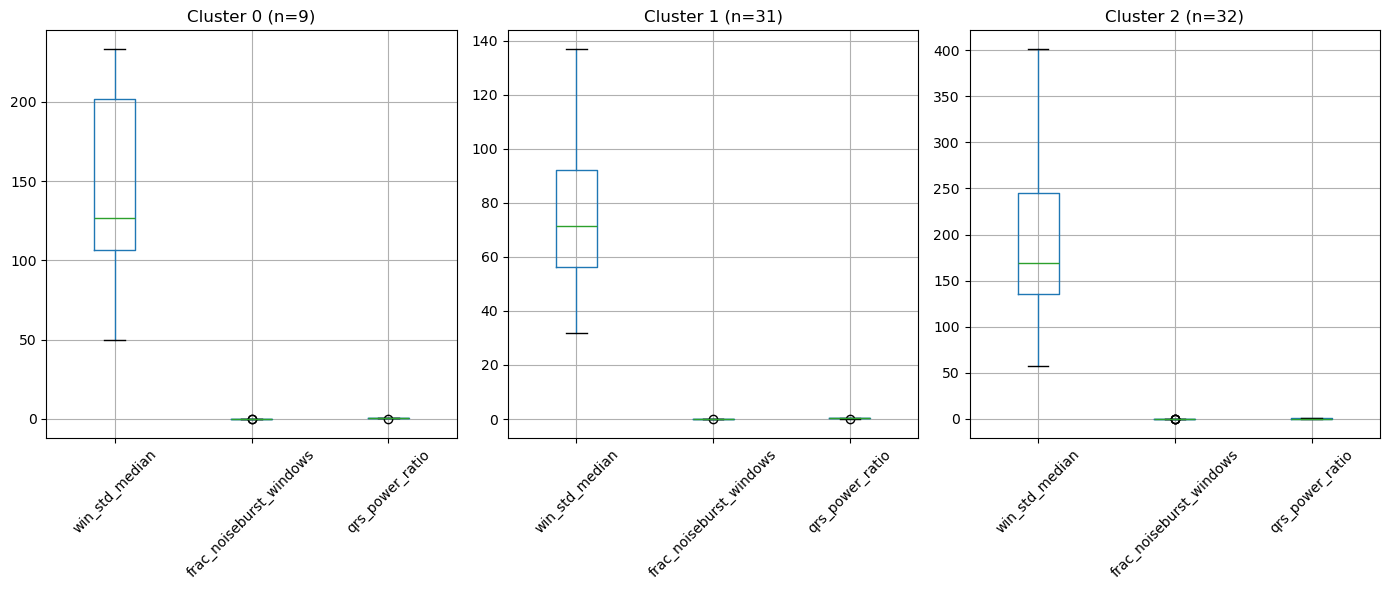

In [7]:
feature_cols = [
    "win_std_median",
    "win_std_p99",
    "frac_noiseburst_windows",
    "frac_flatline_windows",
    "qrs_power_ratio",
    "hf_ratio",
    "lf_ratio",
    "psd_kurtosis",
    "spectral_uniqueness_score", 
]

df_feat = df_quality.dropna(subset=feature_cols).copy()
X = df_feat[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

df_feat["quality_cluster_kmeans"] = cluster_labels

df_quality_clustered = df_quality.merge(
    df_feat[["recording_uid", "quality_cluster_kmeans"]],
    on="recording_uid",
    how="left",
)

df_quality_clustered.to_csv(
    STUDY2_OUT / "recording_quality_clusters.csv",
    index=False,
)

# discriptive statistics per cluster
cluster_summary = df_quality_clustered.groupby("quality_cluster_kmeans")[
    ["win_std_median", "frac_noiseburst_windows", "qrs_power_ratio"]
].describe()
cluster_summary.to_csv(STUDY2_OUT / "recording_quality_clusters_summary.csv")

# Boxplots for the report
plt.figure(figsize=(14, 6))
for idx, cluster in enumerate(
    sorted(df_quality_clustered["quality_cluster_kmeans"].dropna().unique()), start=1
):
    plt.subplot(1, 3, idx)
    cluster_data = df_quality_clustered[
        df_quality_clustered["quality_cluster_kmeans"] == cluster
    ]
    cluster_data[["win_std_median", "frac_noiseburst_windows", "qrs_power_ratio"]].boxplot()
    plt.title(f"Cluster {cluster} (n={len(cluster_data)})")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(STUDY2_OUT / "recording_quality_clusters_boxplots.png", dpi=300)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (nødvendig import)
import matplotlib.pyplot as plt
import numpy as np

feat_x = "win_std_median"
feat_y = "frac_noiseburst_windows"
feat_z = "qrs_power_ratio"

clusters = sorted(df_quality_clustered["cluster"].unique())
n_clusters = len(clusters)

# Vælg farver – brug gerne din egen palette hvis du har en
cluster_colors = {
    0: "#1b9e77",
    1: "#d95f02",
    2: "#7570b3",
}

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

for cl in clusters:
    df_c = df_quality_clustered[df_quality_clustered["cluster"] == cl]
    ax.scatter(
        df_c[feat_x],
        df_c[feat_y],
        df_c[feat_z],
        s=40,
        alpha=0.8,
        color=cluster_colors.get(cl, "C0"),
        label=f"Cluster {cl} (n={len(df_c)})",
    )

ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
ax.set_zlabel(feat_z)
ax.set_title("Recording-level clusters in feature space")
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()


In [ ]:
pairs = [
    ("win_std_median", "qrs_power_ratio"),
    ("win_std_median", "frac_noiseburst_windows"),
    ("qrs_power_ratio", "frac_noiseburst_windows"),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (fx, fy) in zip(axes, pairs):
    for cl in clusters:
        df_c = df_quality_clustered[df_quality_clustered["cluster"] == cl]
        ax.scatter(
            df_c[fx],
            df_c[fy],
            s=30,
            alpha=0.7,
            color=cluster_colors.get(cl, "C0"),
            label=f"Cluster {cl}" if fx == pairs[0][0] and fy == pairs[0][1] else None,
        )
    ax.set_xlabel(fx)
    ax.set_ylabel(fy)

axes[0].legend()
fig.suptitle("2D projections of recording-level clusters", y=1.03)
plt.tight_layout()
plt.show()


In [ ]:
cluster_summary = (
    df_quality_clustered
    .groupby("cluster")[[feat_x, feat_y, feat_z]]
    .median()
    .rename(columns={
        feat_x: "win_std_median_med",
        feat_y: "frac_noiseburst_med",
        feat_z: "qrs_power_ratio_med",
    })
)
cluster_summary

cluster_summary.to_csv(STUDY2_OUT / "cluster_feature_medians.csv")


## Window-level signal quality: baseline vs. seizure
To characterise how signal quality varies around seizures, the recordings are partitioned into short windows, and each window is labelled as either baseline or seizure depending on overlap with the seizure annotations.

Window quality: 100%|██████████| 72/72 [04:16<00:00,  3.56s/it]


Global STD median:
 context
baseline    119.875198
seizure     171.494893
Name: std, dtype: float64

Global RANGE median:
 context
baseline    1016.774349
seizure     1319.296803
Name: range, dtype: float64

Global NOISEBURST rate:
 context
baseline    0.009091
seizure     0.055451
Name: is_noiseburst, dtype: float64


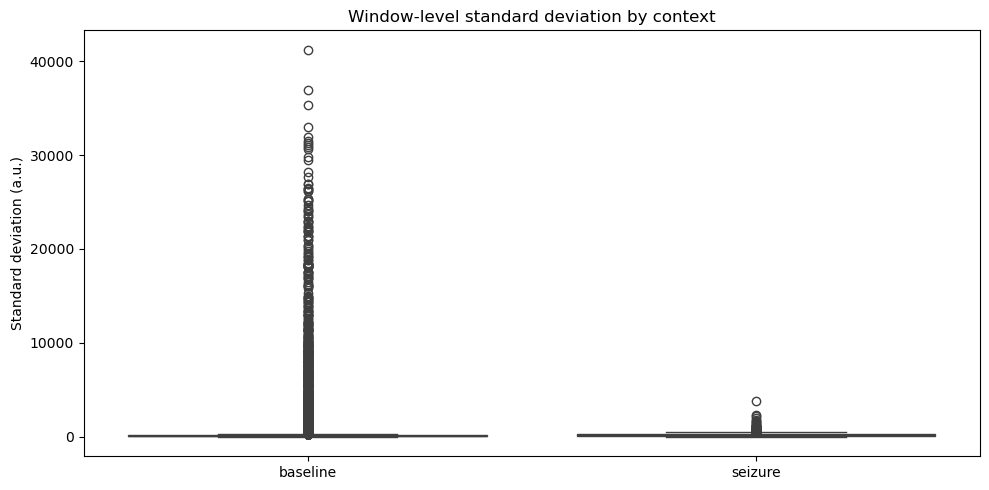

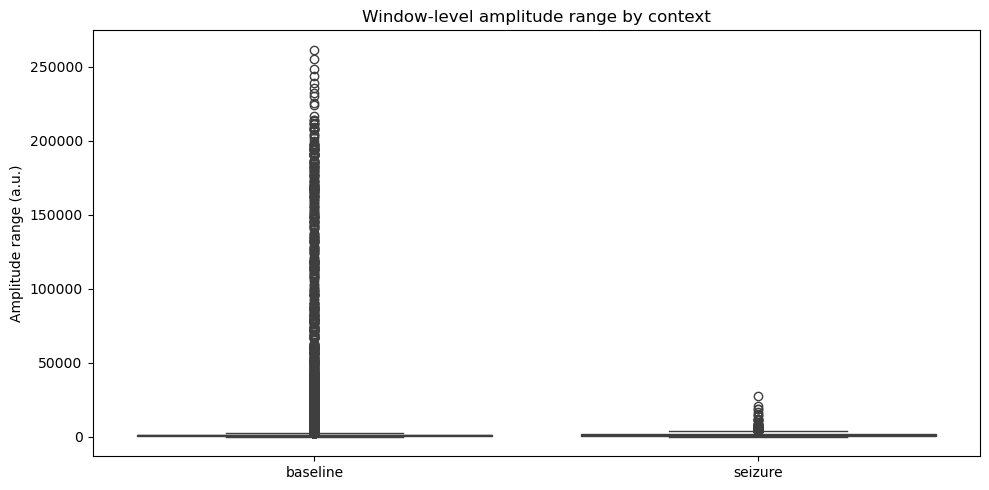

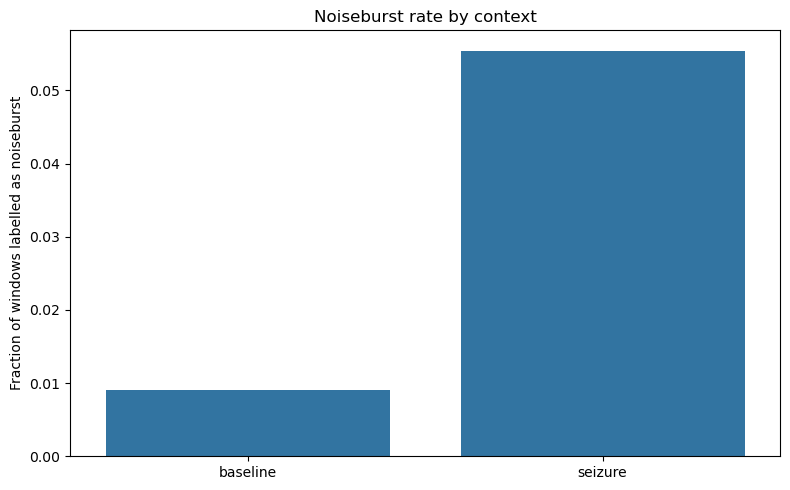

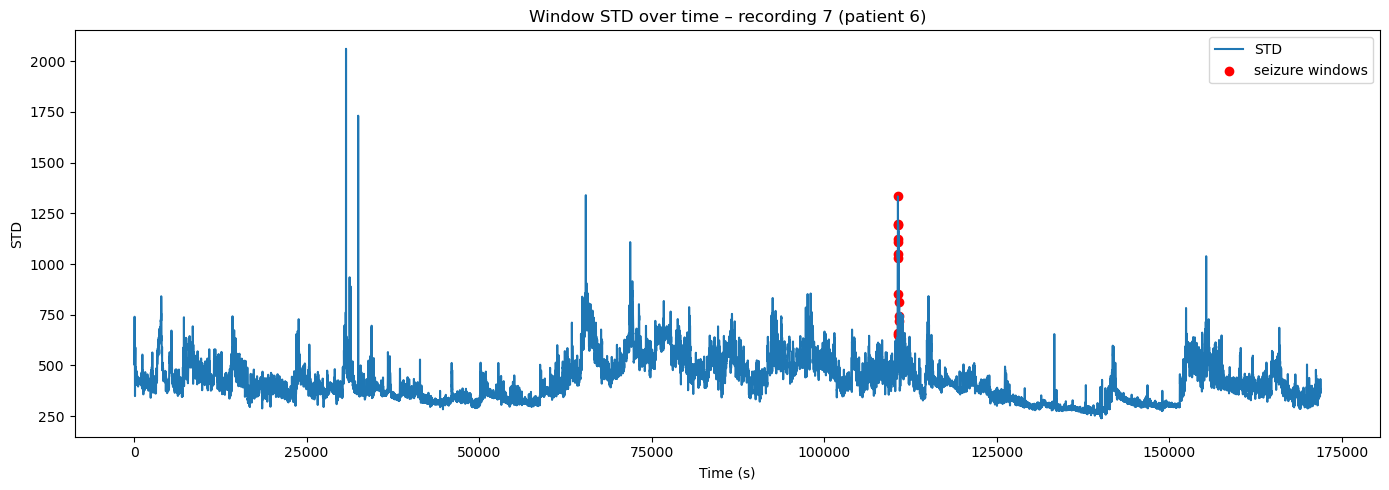

In [8]:
df_win = compute_window_quality_vs_seizure(df_rec, df_evt)

# save for later analysis / plots
df_win_out = STUDY2_OUT / "window_quality_baseline_vs_seizure.csv"
df_win.to_csv(df_win_out, index=False)

# --- patient-specific comparison ---
std_compare = df_win.groupby(["patient_id", "context"])["std"].median().unstack()
range_compare = df_win.groupby(["patient_id", "context"])["range"].median().unstack()
noise_compare = df_win.groupby(["patient_id", "context"])["is_noiseburst"].mean().unstack()

std_compare.to_csv(STUDY2_OUT / "window_std_median_per_patient.csv")
range_compare.to_csv(STUDY2_OUT / "window_range_median_per_patient.csv")
noise_compare.to_csv(STUDY2_OUT / "window_noiseburst_rate_per_patient.csv")

# --- global values (for text in the results section) ---
print("Global STD median:\n", df_win.groupby("context")["std"].median())
print("\nGlobal RANGE median:\n", df_win.groupby("context")["range"].median())
print("\nGlobal NOISEBURST rate:\n", df_win.groupby("context")["is_noiseburst"].mean())

# Boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(x="context", y="std", data=df_win)
plt.title("Window-level standard deviation by context")
plt.ylabel("Standard deviation (a.u.)")
plt.xlabel("")
plt.tight_layout()
plt.savefig(STUDY2_OUT / "window_std_boxplot_baseline_vs_seizure.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x="context", y="range", data=df_win)
plt.title("Window-level amplitude range by context")
plt.ylabel("Amplitude range (a.u.)")
plt.xlabel("")
plt.tight_layout()
plt.savefig(STUDY2_OUT / "window_range_boxplot_baseline_vs_seizure.png", dpi=300)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    x=["baseline", "seizure"],
    y=df_win.groupby("context")["is_noiseburst"].mean().values,
)
plt.title("Noiseburst rate by context")
plt.ylabel("Fraction of windows labelled as noiseburst")
plt.tight_layout()
plt.savefig(STUDY2_OUT / "window_noiseburst_rate_barplot.png", dpi=300)
plt.show()

# Eksempel-figur for én patient (valgfri)
example_patient = 6
rec_ids = df_win[df_win["patient_id"] == example_patient]["recording_uid"].unique()

for rec in rec_ids[:1]:
    df_r = df_win[df_win["recording_uid"] == rec]

    plt.figure(figsize=(14, 5))
    plt.plot(df_r["win_start_s"], df_r["std"], label="STD")
    plt.scatter(
        df_r[df_r["context"] == "seizure"]["win_start_s"],
        df_r[df_r["context"] == "seizure"]["std"],
        color="red",
        label="seizure windows",
    )
    plt.title(f"Window STD over time – recording {rec} (patient {example_patient})")
    plt.xlabel("Time (s)")
    plt.ylabel("STD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(
        STUDY2_OUT / f"window_std_timecourse_patient{example_patient}_rec{rec}.png",
        dpi=300,
    )
    plt.show()

## Construction of the 60-s segment index
In order to support signal quality assessment and seizure-related analyses in later studies, the recordings are partitioned into fixed-length windows.
Using the recording and seizure index from Study 2, a segment index is constructed with 60 s windows labelled as baseline, seizure or other relevant contexts.
For each segment, the index stores the patient identifier, recording identifier, absolute time and context label.
The index is exported as a separate CSV file and reused as a common reference structure in Studies 3–5.

In [9]:
# Segmenterings-parameter (bruges i senere studier)
SEG_WIN_S = 60.0  # 60 s vinduer med den step/overlap som build_segment_index bruger

df_seg_core = build_segment_index(df_rec, df_evt, window_s=SEG_WIN_S, seizure_buffer_s=0)

# Simpel kontrol
df_seg_core.head(), len(df_seg_core)

(   recording_uid  patient_id  recording_id  win_start_s  win_end_s   context
 0              0           1             1          0.0       60.0  baseline
 1              0           1             1         60.0      120.0  baseline
 2              0           1             1        120.0      180.0  baseline
 3              0           1             1        180.0      240.0  baseline
 4              0           1             1        240.0      300.0  baseline,
 195806)

In [10]:
df_seg_ext60 = build_segment_index(
    df_rec,
    df_evt,
    window_s=60,
    seizure_buffer_s=60,
    label_extended=True,
)

df_seg_ext60.to_csv(STUDY2_OUT / "segments_extended60_60s.csv", index=False)

df_seg_ext120 = build_segment_index(
    df_rec,
    df_evt,
    window_s=60,
    seizure_buffer_s=120,
    label_extended=True,
)
df_seg_ext120.to_csv(STUDY2_OUT / "segments_extended120_60s.csv", index=False)

### Comparison of core and extended seizure segments

Using the updated build_segment_index function, three segmentations were generated:

1.  Core ictal segments
    1.  windows overlapping the clinically annotated seizure interval only.
2.  Extended (±60 s)
    1.  including both pre-ictal and post-ictal periods up to 60 s from annotation boundaries.
3.  Extended (±120 s)
    1.  capturing a broader peri-ictal envelope.

These parallel segmentations make it possible to evaluate whether signal characteristics differ systematically between:

*   baseline
*   ictal core
*   peri-ictal windows (pre- and post-ictal)

Such analyses support SO5 (artefact/noise characterisation) and SO6 (context-dependent signal variation) by revealing whether seizure-adjacent periods exhibit transitional behaviour not visible when using only the strict (annotated) ictal intervals.

A. Label comparison: core vs. extended

In [12]:
df_seg_core.head()

,recording_uid,patient_id,recording_id,win_start_s,win_end_s,context
0,0,1,1,0.0,60.0,baseline
1,0,1,1,60.0,120.0,baseline
2,0,1,1,120.0,180.0,baseline
3,0,1,1,180.0,240.0,baseline
4,0,1,1,240.0,300.0,baseline


In [13]:
# Compare label distributions across segmentations

def summarise_label_counts(df_seg, name):
    # Chose the right column: 'label' if it exists, otherwise 'context'
    label_col = "label" if "label" in df_seg.columns else "context"
    c = df_seg[label_col].value_counts().rename(name)
    return c

counts_core = summarise_label_counts(df_seg_core, "core")
counts_ext60 = summarise_label_counts(df_seg_ext60, "ext60")
counts_ext120 = summarise_label_counts(df_seg_ext120, "ext120")

df_label_compare = pd.concat([counts_core, counts_ext60, counts_ext120], axis=1).fillna(0)
df_label_compare.to_csv(STUDY2_OUT / "segment_label_comparison.csv")

df_label_compare



,core,ext60,ext120
context,,,
baseline,195490.0,195192,194896
seizure_core,316.0,316,316
seizure_extended,0.0,298,594


B. Visualizing changes in amount of segments

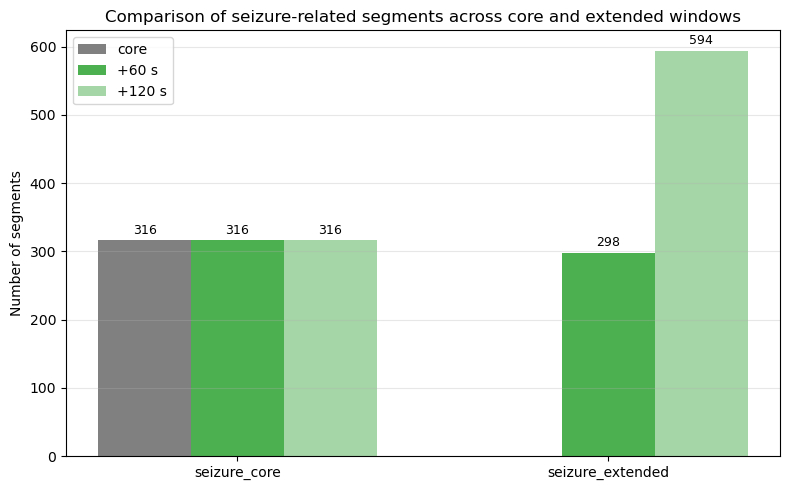

Udvidelse +60 s:  94.3% flere ictale segmenter samlet
Udvidelse +120 s: 188.0% flere ictale segmenter samlet


In [ ]:
# --- Kun ictale labels ---
df_compare_no_baseline = df_label_compare.loc[
    ["seizure_core", "seizure_extended"]
].copy()

# x-positioner: én pr. label
labels = df_compare_no_baseline.index.tolist()   # ["seizure_core", "seizure_extended"]
x = np.arange(len(labels))

core_vals   = df_compare_no_baseline["core"].values
ext60_vals  = df_compare_no_baseline["ext60"].values
ext120_vals = df_compare_no_baseline["ext120"].values

width = 0.25

plt.figure(figsize=(8, 5))

b1 = plt.bar(x - width, core_vals,   width, label="core",   color='gray')
b2 = plt.bar(x,         ext60_vals,  width, label="+60 s",  color=palette["primary"])
b3 = plt.bar(x + width, ext120_vals, width, label="+120 s", color=palette["secondary"])

plt.xticks(x, labels, rotation=0)
plt.ylabel("Number of segments")
plt.title("Comparison of seizure-related segments across core and extended windows")
plt.grid(axis="y", alpha=0.3)
plt.legend()

# --- Annotér søjler med absolutte tal ---
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        if height <= 0:
            continue
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 5,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

annotate_bars(b1)
annotate_bars(b2)
annotate_bars(b3)

plt.tight_layout()
plt.show()

# Total ictale segmenter (core + extended) for hver strategi
total_core   = df_label_compare.loc[["seizure_core", "seizure_extended"], "core"].sum()
total_ext60  = df_label_compare.loc[["seizure_core", "seizure_extended"], "ext60"].sum()
total_ext120 = df_label_compare.loc[["seizure_core", "seizure_extended"], "ext120"].sum()

pct_60  = (total_ext60  / total_core - 1) * 100
pct_120 = (total_ext120 / total_core - 1) * 100

print(f"Udvidelse +60 s:  {pct_60:.1f}% flere ictale segmenter samlet")
print(f"Udvidelse +120 s: {pct_120:.1f}% flere ictale segmenter samlet")

C. Analysis of amplitude / noise-metrics in each segment type

In [32]:
# Join window metrics and segment contexts
df_join_core = df_win.merge(
    df_seg_core[["recording_uid", "win_start_s", "context"]],
    on=["recording_uid", "win_start_s"],
    how="left"
)

df_join_ext60 = df_win.merge(
    df_seg_ext60[["recording_uid", "win_start_s", "context"]],
    on=["recording_uid", "win_start_s"],
    how="left"
)

df_join_ext120 = df_win.merge(
    df_seg_ext120[["recording_uid", "win_start_s", "context"]],
    on=["recording_uid", "win_start_s"],
    how="left"
)


In [35]:
df_join_core.head()

,recording_uid,patient_id,recording_id,window_idx,win_start_s,win_end_s,context_x,std,range,diff_abs_med,is_flatline,is_noiseburst,is_clipping,context_y
0,0,1,1,0,0.0,10.0,baseline,4845.317329,52274.015691,30.211861,False,True,False,baseline
1,0,1,1,1,10.0,20.0,baseline,394.380965,4671.761620,2.346228,False,False,False,NaN
2,0,1,1,2,20.0,30.0,baseline,282.427707,2827.753158,2.135254,False,False,False,NaN
3,0,1,1,3,30.0,40.0,baseline,223.624380,1904.471664,1.297127,False,False,False,NaN
4,0,1,1,4,40.0,50.0,baseline,1476.413101,14641.533797,3.095491,False,True,False,NaN


In [41]:
from src.hrv_epatch.analysis.segments import describe_by_label

# Brug funktionen på de tre joinede datasæt
core_stats   = describe_by_label(df_join_core,   "core")
ext60_stats  = describe_by_label(df_join_ext60,  "ext60")
ext120_stats = describe_by_label(df_join_ext120, "ext120")

df_seg_stats = pd.concat([core_stats, ext60_stats, ext120_stats], axis=1)
df_seg_stats.to_csv(STUDY2_OUT / "segment_quality_stats_core_vs_extended.csv")

df_seg_stats


,std_core,range_core,noise_core,std_ext60,range_ext60,noise_ext60,std_ext120,range_ext120,noise_ext120
context_x,,,,,,,,,
baseline,119.875198,1016.774349,0.0,119.875198,1016.774349,0.0,119.875198,1016.774349,0.0
seizure,171.494893,1319.296803,0.0,171.494893,1319.296803,0.0,171.494893,1319.296803,0.0


D. Boxplot: signal STD across segmentcates

In [46]:
for df_join in (df_join_core, df_join_ext60, df_join_ext120):
    if "context_y" in df_join.columns:
        df_join["label"] = df_join["context_y"].fillna(df_join.get("context_x", np.nan))
    elif "context_x" in df_join.columns:
        df_join["label"] = df_join["context_x"]

In [47]:
df_join_ext120.head()

,recording_uid,patient_id,recording_id,window_idx,win_start_s,win_end_s,context_x,std,range,diff_abs_med,is_flatline,is_noiseburst,is_clipping,context_y,label
0,0,1,1,0,0.0,10.0,baseline,4845.317329,52274.015691,30.211861,False,True,False,baseline,baseline
1,0,1,1,1,10.0,20.0,baseline,394.380965,4671.761620,2.346228,False,False,False,NaN,baseline
2,0,1,1,2,20.0,30.0,baseline,282.427707,2827.753158,2.135254,False,False,False,NaN,baseline
3,0,1,1,3,30.0,40.0,baseline,223.624380,1904.471664,1.297127,False,False,False,NaN,baseline
4,0,1,1,4,40.0,50.0,baseline,1476.413101,14641.533797,3.095491,False,True,False,NaN,baseline


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7616\3726529948.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


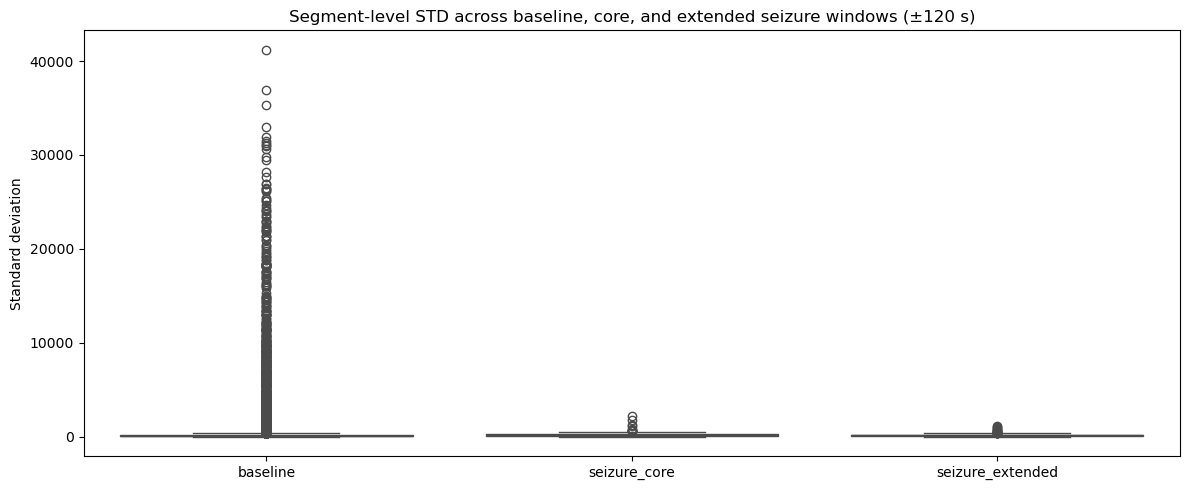

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Filtrér til de tre relevante labels (for at undgå NaN/andre labels)
df_plot = df_join_ext120[df_join_ext120["label"].isin(
    ["baseline", "seizure_core", "seizure_extended"]
)]

sns.boxplot(
    x="label",
    y="std",
    data=df_plot,
    order=["baseline", "seizure_core", "seizure_extended"],
    palette=[palette["primary"], palette["secondary"], "gray"],
)

plt.title("Segment-level STD across baseline, core, and extended seizure windows (±120 s)")
plt.ylabel("Standard deviation")
plt.xlabel("")
plt.tight_layout()
plt.savefig(STUDY2_OUT / "segment_std_boxplot_extended120.png", dpi=300)
plt.show()


Saved figure to: E:\Speciale - Results\Datastruct\_analysis\study2\std_timecourse_ext120_patient6_rec7.png


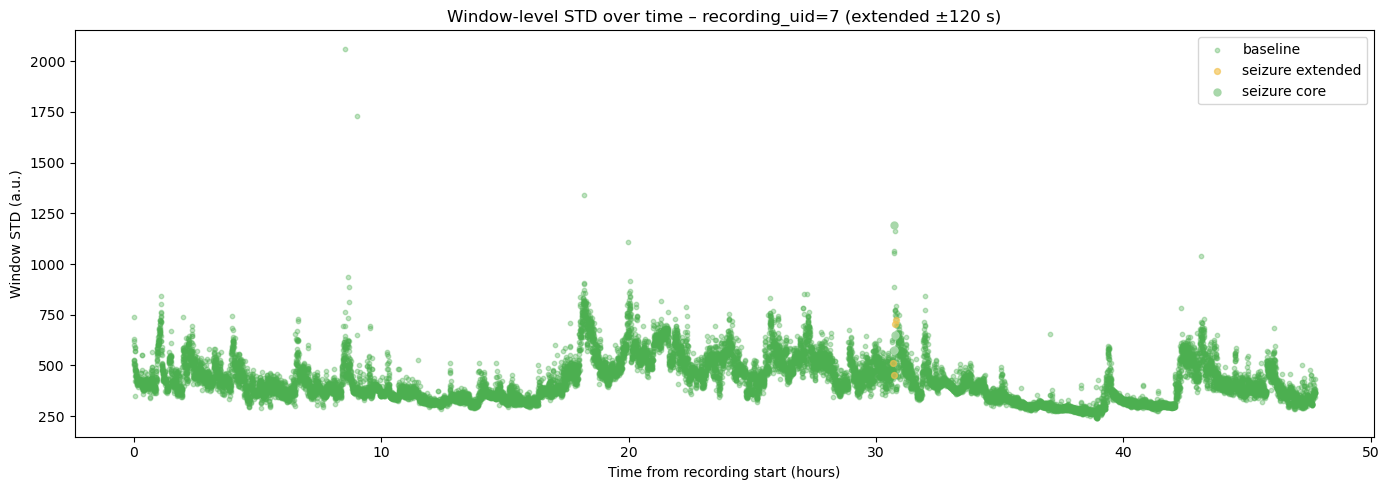

In [ ]:
from src.hrv_epatch.plots.timecourse_plot import plot_std_timecourse_by_label, plot_all_std_timecourses

example_patient = 6

rec_ids = (
    df_join_ext120[df_join_ext120["patient_id"] == example_patient]["recording_uid"]
    .unique()
)

rec_ids

if len(rec_ids) > 0:
    rec = rec_ids[0]
    outpath = STUDY2_OUT / f"std_timecourse_ext120_patient{example_patient}_rec{rec}.png"
    plot_std_timecourse_by_label(
        df_join_ext120,
        recording_uid=rec,
        outpath=outpath,
        title_suffix="extended ±120 s",
    )
else:
    print(f"No recordings found for patient {example_patient}")


Saved figure to: E:\Speciale - Results\Datastruct\_analysis\study2\std_timecourse_ext120_patient6_rec7.png


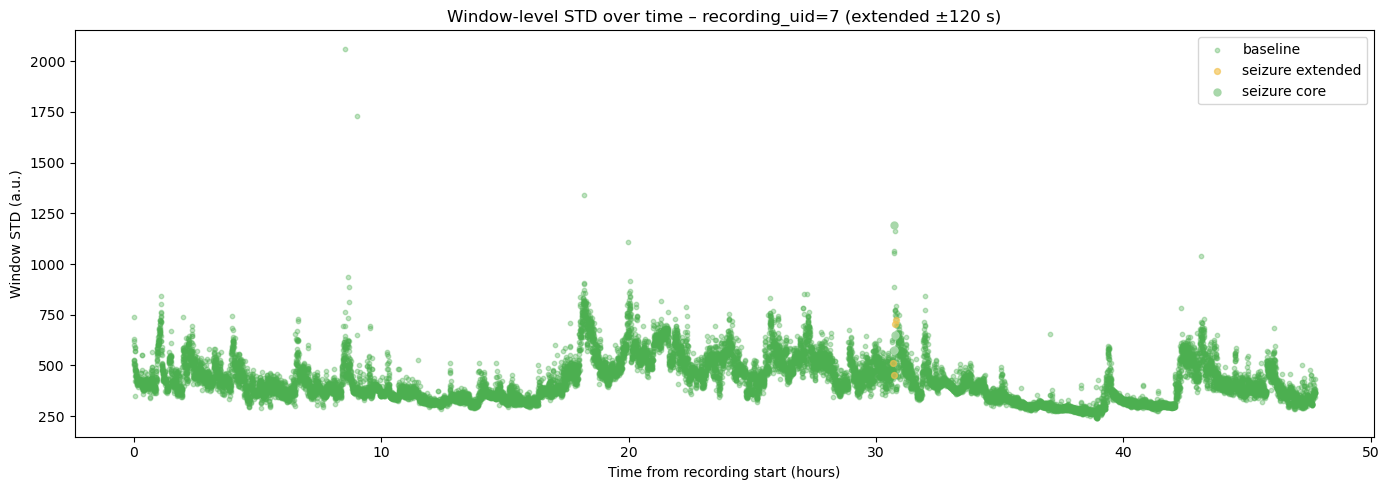

Saved figure to: E:\Speciale - Results\Datastruct\_analysis\study2\std_timecourse_ext120_patient6_rec8.png


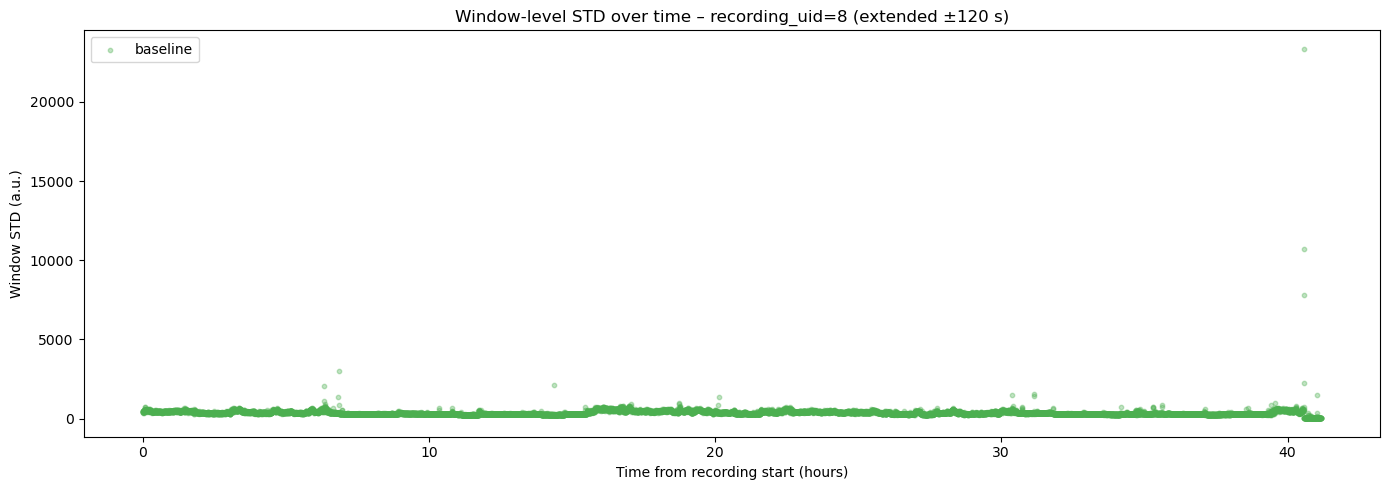

In [ ]:
for rec in rec_ids[:3]:
    outpath = STUDY2_OUT / f"std_timecourse_ext120_patient{example_patient}_rec{rec}.png"
    plot_std_timecourse_by_label(
        df_join_ext120,
        recording_uid=rec,
        outpath=outpath,
        title_suffix="extended ±120 s",
    )

In [ ]:
OUT_STD_PLOTS = STUDY2_OUT / "std_timecourses_ext120"

plot_all_std_timecourses(
    df_join=df_join_ext120,   # eller df_join_core / df_join_ext60
    df_rec=df_rec,
    outdir=OUT_STD_PLOTS,
    title_suffix="extended ±120 s",
)


In [ ]:
SEG_OUT = OUT_DIR / f"segment_index_{int(SEG_WIN_S)}s.csv"
df_seg_core.to_csv(SEG_OUT, index=False)
print("Saved segment index to:", SEG_OUT)
